In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools
import json

# Import data
- all thresholds: df_both_sessions

In [3]:
df_both_sessions = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

In [4]:
num_thresholds_per_subj = 18
assert df_both_sessions["prolificID"].nunique() == len(df_both_sessions) / num_thresholds_per_subj, 'Fatal: Number of thresholds per subject does not match'

print(f'\nNumber of participants with both sessions: {df_both_sessions["prolificID"].nunique()}')


Number of participants with both sessions: 169


In [5]:
# Update meridian values for reading tasks
# df_both_sessions.loc[
#     (df_both_sessions['taskName'] == 'reading') & 
#     (df_both_sessions['meridian'].isin(['Beaver', 'Desert'])),
#     'meridian'
# ] = 'first'

# df_both_sessions.loc[
#     (df_both_sessions['taskName'] == 'reading') & 
#     (df_both_sessions['meridian'].isin(['Winter', 'Islands'])),
#     'meridian'
# ] = 'second'

# Data cleaning

## Import prolificIDs that we want to exclude

In [6]:
# import participant lists from file
with open("exclude_dict.json", "r") as f:
    exclude_dict = json.load(f)


# for task, exclude_ids in exclude_dict.items():
#     df_both_sessions = df_both_sessions[
#         ~(
#             (df_both_sessions["taskName"] == task)
#             & (df_both_sessions["prolificID"].isin(exclude_ids))
#         )
#     ]


## Compute the geometric mean of thresholds
- within the same block (one threshold per block): df_gmean_block
- across blocks for each task (one threshold per task): df_gmean_task
- within the same meridian (one threshold per meridian): df_gmean_meridian
- all data are logged so we can simply take the mean

In [7]:
# Group by participant, task, and repeat
df_gmean_block = (
    df_both_sessions.groupby(["prolificID", "taskName", "repeat"], observed=True)
					.agg(gmean_threshold_block=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_block

,prolificID,taskName,repeat,gmean_threshold_block
0,559ad287fdf99b219a612d22,acuity,1,-0.415187
1,559ad287fdf99b219a612d22,acuity,2,-0.480609
2,559ad287fdf99b219a612d22,crowding,1,0.845687
3,559ad287fdf99b219a612d22,crowding,2,0.882659
4,559ad287fdf99b219a612d22,crowding,3,0.950354
...,...,...,...,...
1685,67fffee26ec983c07f3a2abd,crowding,4,0.140155
1686,67fffee26ec983c07f3a2abd,reading,1,2.102490
1687,67fffee26ec983c07f3a2abd,reading,2,2.279796
1688,67fffee26ec983c07f3a2abd,rsvp,1,2.543958


In [8]:
# Group by participant, task, and repeat
df_gmean_task = (
    df_both_sessions.groupby(["prolificID", "taskName"], observed=True)
					.agg(gmean_threshold_task=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_task

,prolificID,taskName,gmean_threshold_task
0,559ad287fdf99b219a612d22,acuity,-0.447898
1,559ad287fdf99b219a612d22,crowding,0.929865
2,559ad287fdf99b219a612d22,reading,2.278744
3,559ad287fdf99b219a612d22,rsvp,2.633234
4,55d51a6b8ce09000127d4821,acuity,-0.633734
...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.175839
672,67fffee26ec983c07f3a2abd,acuity,-0.476663
673,67fffee26ec983c07f3a2abd,crowding,0.352948
674,67fffee26ec983c07f3a2abd,reading,2.191143


In [9]:
# Group by participant, task, and repeat
df_gmean_meridian = (
    df_both_sessions.groupby(["prolificID", "taskName","meridian"], observed=True)
					.agg(gmean_threshold_meridian=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_meridian

,prolificID,taskName,meridian,gmean_threshold_meridian
0,559ad287fdf99b219a612d22,acuity,L8,-0.415579
1,559ad287fdf99b219a612d22,acuity,R8,-0.480217
2,559ad287fdf99b219a612d22,crowding,L8,1.094984
3,559ad287fdf99b219a612d22,crowding,R8,0.764746
4,559ad287fdf99b219a612d22,reading,Beaver,2.324647
...,...,...,...,...
1516,67fffee26ec983c07f3a2abd,reading,Beaver,2.156616
1517,67fffee26ec983c07f3a2abd,reading,Desert,2.396606
1518,67fffee26ec983c07f3a2abd,reading,Islands,2.162986
1519,67fffee26ec983c07f3a2abd,reading,Winter,2.048363


# Analysis
- note that everything in is now logged

### Functions

In [10]:
def filter_task_df(df, taskName, exclude_dict):
    '''
    filter data by number of trials, questSD, and test-retest ratio for a given task.
    '''
    df_task_raw = df[df['taskName'] == taskName]
    df_cleaned = df_task_raw[~df_task_raw["prolificID"].isin(exclude_dict[taskName])].copy()

    return df_cleaned

In [11]:
def plot_scatter_with_correlation(var_x, var_y, var_x_name, var_y_name, plotXequalsY_bool=False, equal_axes_bool=True):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        var_x (list): first variable extracted from a df
        var_y (list): second variable extracted from a df
    """
    var_x = np.array(var_x)
    var_y = np.array(var_y)

	# print out minimum and maximum values of the variables
    min_x = var_x.min()
    min_y = var_y.min()
    max_x = var_x.max()
    max_y = var_y.max()
    print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')
    
    # Compute Pearson correlation
    valid = (~np.isnan(var_x)) & (~np.isnan(var_y))
    r, p_value = stats.pearsonr(var_x[valid], var_y[valid])

    # Determine axis limits (same for both axes)
    min_val = min(var_x.min(), var_y.min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(var_x.max(), var_y.max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=var_x, y=var_y, s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    if equal_axes_bool:
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('equal')


    else:
        plt.gca().set_aspect('auto', adjustable='box')  


    # Add title with Pearson's r value
    plt.title(f"measured r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x_name, fontsize=14)
    plt.ylabel(var_y_name, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Show plot
    plt.show()


In [12]:
def make_task_wide(block_df, task_df, task_name):
    """
    block_df: columns ['prolificID','taskName','repeat','gmean_threshold_block']
    task_df : columns ['prolificID','taskName','repeat','gmean_threshold_task']
    returns: wide df with columns like ['prolificID', f'{task}_block1', ..., f'{task}_grandMean']
    """

    # 1) pivot blocks → one column per repeat
    wide_blocks = (block_df
                   .pivot(index="prolificID", columns="repeat", values="gmean_threshold_block")
                   .sort_index(axis=1))  # ensure block1, block2, ...

    # rename e.g. 1→'acuity_block1'
    wide_blocks.columns = [f"{task_name}_block{int(c)}" for c in wide_blocks.columns]

    # 2) grand mean per participant (use task_df; if multiple rows, average them)
    grand = (task_df
             .groupby("prolificID", as_index=True)["gmean_threshold_task"]
             .mean()
             .rename(f"{task_name}_grandMean")
             .to_frame())

    # combine and return
    out = wide_blocks.join(grand, how="outer").reset_index()
    return out


def build_big_df(task_to_dfs):
    """
    task_to_dfs: dict like {
        'acuity':   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
        'crowding': (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
        'rsvp':     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
        'reading':  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
    }
    returns one big df with prolificID rows and all task columns.
    """
    pieces = []
    for task, (block_df, task_df) in task_to_dfs.items():
        w = make_task_wide(block_df, task_df, task)
        pieces.append(w.set_index("prolificID"))

    big = pd.concat(pieces, axis=1)  # outer join on prolificID
    big = big.reset_index()
    return big

# Columns look like:
# ['prolificID', 'acuity_block1','acuity_block2',...,'acuity_grandMean',
#  'crowding_block1',...,'crowding_grandMean', 'rsvp_block1',...,'reading_grandMean']



### Filter data

In [15]:
acuity_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'acuity', exclude_dict)
crowding_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'crowding', exclude_dict)
rsvp_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'rsvp', exclude_dict)
reading_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'reading', exclude_dict) 

acuity_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'acuity', exclude_dict)
crowding_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'crowding', exclude_dict)
rsvp_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'rsvp', exclude_dict)
reading_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'reading', exclude_dict) 

In [16]:
# # sanity check for RSVP: if we don't exclude by test-retest ratio, we get really low r(test, retest)
# rsvp_tt = filter_task_df(df_gmean_block, 'rsvp', rsvp_low_trial_ids, [], [])
# rsvp_wide = rsvp_tt.pivot_table(
#     index=['prolificID'], columns='repeat', values='gmean_threshold_block'
# )
# rsvp_wide = rsvp_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

# rsvp_r, p = stats.pearsonr(rsvp_wide['repeat1'], rsvp_wide['repeat2'])
# print(rsvp_r)

### Create and save pivot table for correlation analysis

In [17]:
task_to_dfs = {
    "acuity":   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
    "crowding": (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
    "rsvp":     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
    "reading":  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
}

big_df = build_big_df(task_to_dfs)

display(big_df.head())

,prolificID,acuity_block1,acuity_block2,acuity_grandMean,crowding_block1,crowding_block2,crowding_block3,crowding_block4,crowding_grandMean,rsvp_block1,rsvp_block2,rsvp_grandMean,reading_block1,reading_block2,reading_grandMean
0,559ad287fdf99b219a612d22,-0.415187,-0.480609,-0.447898,0.845687,0.882659,0.950354,1.040760,0.929865,2.523579,2.742889,2.633234,2.322498,2.234990,2.278744
1,55d51a6b8ce09000127d4821,-0.596659,-0.670809,-0.633734,0.089592,0.041552,0.119450,-0.103568,0.036757,NaN,NaN,NaN,2.398362,2.281513,2.339937
2,5685850c333cbd000d4e042f,-0.494388,-0.540586,-0.517487,NaN,NaN,NaN,NaN,NaN,3.252130,3.274171,3.263151,2.344673,2.411041,2.377857
3,56b78f11e77ebe000cbefe79,-0.463865,-0.440105,-0.451985,NaN,NaN,NaN,NaN,NaN,3.038510,3.251385,3.144948,2.538969,2.422927,2.480948
4,57334d427d01ed00098e8e69,-0.526725,-0.552582,-0.539654,0.365720,0.148872,0.053535,0.335556,0.225920,3.198827,3.096109,3.147468,2.393182,2.268736,2.330959


In [18]:
# big_df.to_csv('tidy_corr_data_short_staircase_log.csv', index=False)

## Test-retest

In [25]:
print(crowding_gmean_block_cleaned_df.head())

                  prolificID  taskName  repeat  gmean_threshold_block
2   559ad287fdf99b219a612d22  crowding       1               0.845687
3   559ad287fdf99b219a612d22  crowding       2               0.882659
4   559ad287fdf99b219a612d22  crowding       3               0.950354
5   559ad287fdf99b219a612d22  crowding       4               1.040760
12  55d51a6b8ce09000127d4821  crowding       1               0.089592


Min and max values: min_x: -0.284862644, max_x: 0.845686695, min_y: -0.28864219649999995, max_y: 0.901201004


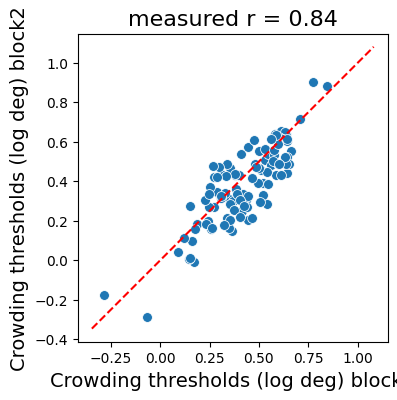

In [26]:
plot_scatter_with_correlation(crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'Crowding thresholds (log deg) block1', 'Crowding thresholds (log deg) block2', plotXequalsY_bool=True)

Min and max values: min_x: -0.4322539585, max_x: 0.950354103, min_y: -0.4087124225, max_y: 1.04075982


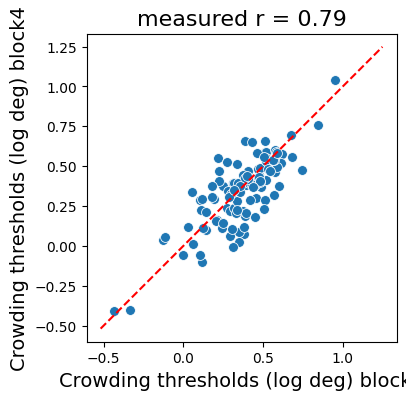

In [27]:
plot_scatter_with_correlation(crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==3]['gmean_threshold_block'],
                              crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==4]['gmean_threshold_block'], 
                              'Crowding thresholds (log deg) block3', 'Crowding thresholds (log deg) block4', plotXequalsY_bool=True)


Min and max values: min_x: 2.5235793143836434, max_x: 3.4836478153836437, min_y: 2.6731146023836434, max_y: 3.4836478153836437


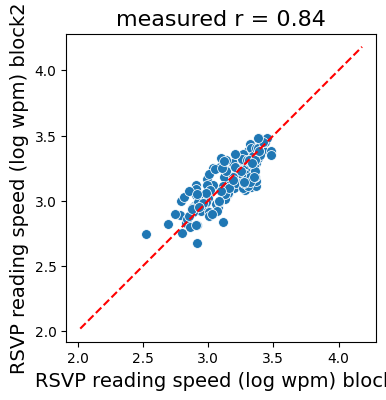

In [28]:
plot_scatter_with_correlation(rsvp_gmean_block_cleaned_df[rsvp_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              rsvp_gmean_block_cleaned_df[rsvp_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'RSVP reading speed (log wpm) block1', 'RSVP reading speed (log wpm) block2', plotXequalsY_bool=True)


Min and max values: min_x: 2.0150021020110365, max_x: 3.064826648227821, min_y: 1.9831391354309837, max_y: 2.7901056705794165


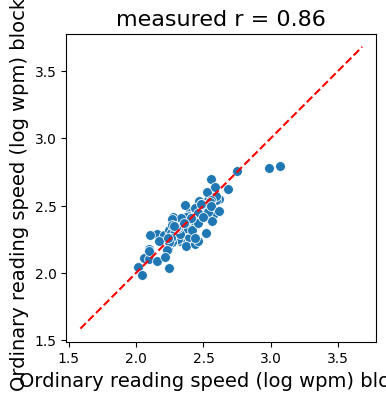

In [29]:
plot_scatter_with_correlation(reading_gmean_block_cleaned_df[reading_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              reading_gmean_block_cleaned_df[reading_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'Ordinary reading speed (log wpm) block1', 'Ordinary reading speed (log wpm) block2', plotXequalsY_bool=True)


## Correlation between tasks

### Scatter plots with measured R

Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


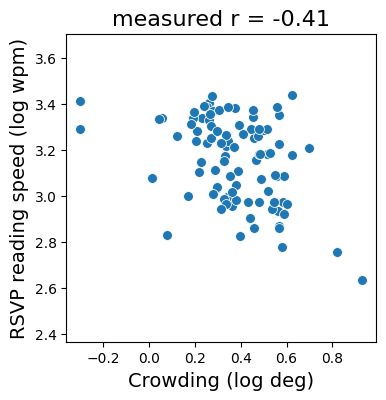

In [32]:
plot_scatter_with_correlation(big_df['crowding_grandMean'],
                              big_df['rsvp_grandMean'], 
                              'Crowding (log deg)', 'RSVP reading speed (log wpm)')


Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


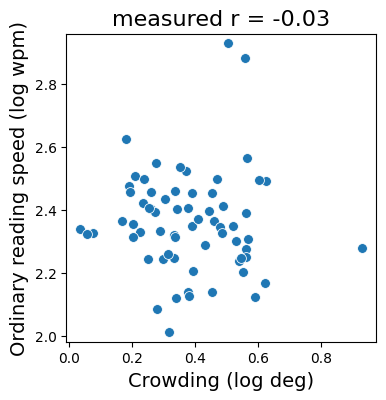

In [33]:
plot_scatter_with_correlation(big_df['crowding_grandMean'],
                              big_df['reading_grandMean'], 
                              'Crowding (log deg)', 'Ordinary reading speed (log wpm)')


Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


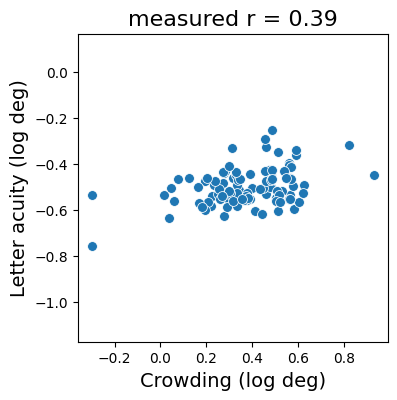

In [34]:
plot_scatter_with_correlation(big_df['crowding_grandMean'],
                              big_df['acuity_grandMean'], 
                              'Crowding (log deg)', 'Letter acuity (log deg)')

Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


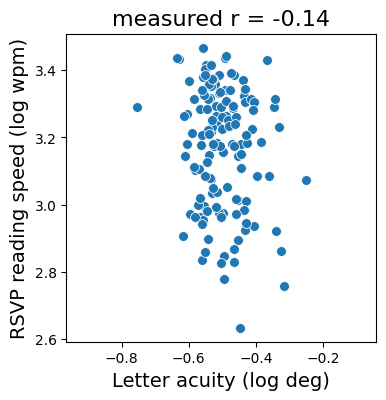

In [35]:
plot_scatter_with_correlation(big_df['acuity_grandMean'],
                              big_df['rsvp_grandMean'], 
                              'Letter acuity (log deg)', 'RSVP reading speed (log wpm)')

Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


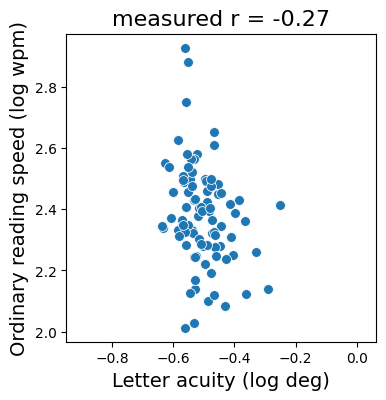

In [36]:
plot_scatter_with_correlation(big_df['acuity_grandMean'],
                              big_df['reading_grandMean'], 
                              'Letter acuity (log deg)', 'Ordinary reading speed (log wpm)')

### Calculate and display measured and corrected R

#### Functions:

In [37]:
def summarize_task(X):
    """
    df_task: long df with columns ['prolificID','repeat','gmean_threshold_block'] (taskName can be present/ignored)
    Returns a Series with within/between variances, grand mean, and noise ceiling.
    """

    # per-participant mean across repeats
    subj_mean = X.mean(axis=1, skipna=True)

    # stats
    within_var = X.var(axis=1, ddof=1).mean(skipna=True)
    between_var = np.nanvar(subj_mean.to_numpy(), ddof=1)
    grand_mean = subj_mean.mean(skipna=True)

    # split-half reliability → Spearman–Brown
    if X.shape[1] < 2:
        r_ceiling = np.nan
    else:
        n = X.shape[1]
        first, last = X.iloc[:, :n//2].mean(axis=1), X.iloc[:, n//2:].mean(axis=1)
        odd, even  = X.iloc[:, 1::2].mean(axis=1), X.iloc[:, 0::2].mean(axis=1)

        def r(a,b):
            a, b = a.to_numpy(), b.to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            return np.nan if m.sum() < 3 else stats.pearsonr(a[m], b[m])[0]

        r_FL, r_OE = r(first,last), r(odd,even)
        r_i = np.sqrt(r_FL * r_OE) if np.isfinite(r_FL) and np.isfinite(r_OE) else np.nan
        if np.isnan(r_i):
            r_ceiling = np.nan
        else:
            r_i = float(np.clip(r_i, 0.0, 0.999999))
            r_ceiling = (2 * r_i) / (1 + r_i)

    return pd.Series({
        "within_subj_variance": within_var,
        "btw_subj_variance": between_var,
        "mean": grand_mean,
        "r(test,retest)": r_i,
        "r_ceiling": r_ceiling
    })

def summarize_many(task_dfs):
    """
    task_dfs: dict like {'acuity': df_acuity, 'crowding': df_crowding, ...}
    Returns one row per task.
    """
    rows = []
    for task, df_task_wide in task_dfs.items():
        s = summarize_task(df_task_wide)
        s.name = task
        rows.append(s)
    return pd.DataFrame(rows).reset_index(names="task")

def pivot_for_summarize(df, columnNames="repeat", valueNames="gmean_threshold_block"):
    """
    df: long df with columns ['prolificID','taskName','repeat','gmean_threshold_block']
    returns: wide df with one row per participant and one column per repeat
    """
    X = df.pivot(index="prolificID", columns=columnNames, values=valueNames).sort_index(axis=1)
    return X


In [38]:
def print_measured_corrected_r(df, var_x, var_y, r_ceiling_x, r_ceiling_y):
    """
    Compute and print measured and corrected Pearson correlations between two variables.

    Parameters:
        df (pd.DataFrame): Data containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
        r_ceiling_x (float): Noise ceiling (reliability) for var_x.
        r_ceiling_y (float): Noise ceiling (reliability) for var_y.

    Returns:
        pd.DataFrame: Single-row dataframe with results.
    """
    df = df.copy()
    
    # Filter for non-NaN pairs
    valid_mask = df[[var_x, var_y]].notna().all(axis=1)
    x_vals = df.loc[valid_mask, var_x]
    y_vals = df.loc[valid_mask, var_y]

    # Compute measured correlation
    r_measured, p_value = stats.pearsonr(x_vals, y_vals)

    # Compute combined noise ceiling
    r_ceiling_combined = np.sqrt(r_ceiling_x * r_ceiling_y)

    # Apply correction
    r_corrected = r_measured / r_ceiling_combined

    # Return results in dataframe form
    return pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [r_ceiling_x],
        'noise_ceiling_y': [r_ceiling_y],
        'noise_ceiling_combined': [r_ceiling_combined],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })


In [39]:
def create_corr_df(df_data, df_r_ceiling, var_ceiling_pairs):
    """
    Create a correlation matrix for the given DataFrame and noise ceiling DataFrame.

    Parameters:
        df_data (pd.DataFrame): DataFrame containing the data to correlate.
        df_r_ceiling (pd.DataFrame): DataFrame containing the noise ceilings.
        var_ceiling_pairs (dict): Dictionary mapping variable names to their noise ceiling names.
        log10_bool (bool): Whether to apply log10 transformation to the data.

    Returns:
        pd.DataFrame: Correlation matrix with measured and corrected correlations.
    """
    df_data = df_data.copy()
    df_r_ceiling = df_r_ceiling.copy()
    results = []
    
    for var_x, var_y in itertools.combinations(df_data.columns, 2):
        r_ceiling_x = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_x], 'r_ceiling'].values[0]
        r_ceiling_y = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_y], 'r_ceiling'].values[0]
        
        result = print_measured_corrected_r(
            df_data,
            var_x=var_x,
            var_y=var_y,
            r_ceiling_x=r_ceiling_x,
            r_ceiling_y=r_ceiling_y
        )
        
        results.append(result)

    return pd.concat(results, ignore_index=True)

In [40]:
def create_corr_mtx(df_long, all_tasks_summary, var_ceiling_pairs, value_col="r_measured"):

    vars_all = sorted(set(df_long["var_x"]).union(df_long["var_y"]))
    R = pd.DataFrame(np.nan, index=vars_all, columns=vars_all, dtype=float)

    for _, row in df_long.iterrows():
        x, y, val = row["var_x"], row["var_y"], row[value_col]
        R.loc[x, y] = val
        R.loc[y, x] = val


    # map each matrix label to its task name
    tasks_for_vars = pd.Index(R.index).map(var_ceiling_pairs)
    # pull the corresponding r(test,retest) values
    diag_series = all_tasks_summary.set_index("task")["r(test,retest)"]
    diag_vals = diag_series.reindex(tasks_for_vars).to_numpy()
    # write to the diagonal
    ii = np.diag_indices_from(R.values)
    R.values[ii] = diag_vals

    # np.fill_diagonal(R.values, 1.0)
    return R


def plot_mtx_heatmap(R, title=None, mask_upper=True, fontSize=10,
                    valmin=-1, valmax=1, colormap="RdBu_r"):
    """
    Plot a heatmap from the long correlation table.
    
    Parameters:
        df_long: output from create_corr_df(...)
        value_col: 'r_measured' or 'r_corrected'
        mask_upper: True = show only lower triangle for readability
    """

    mask = None
    if mask_upper:
        mask = np.zeros_like(R, dtype=bool)
        mask[np.triu_indices_from(mask, k=1)] = True  # mask above-diagonal

    plt.figure(figsize=(9, 8))
    ax = sns.heatmap(
        R, annot=True, fmt=".2f", cmap=colormap,
        vmin=valmin, vmax=valmax, square=True, #, center=0
        mask=mask, cbar_kws={"label": "r"},
        annot_kws={"size": fontSize}
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.show()



#### Correlations between tasks

In [41]:
block_dfs = {
    "acuity": big_df[[col for col in big_df.columns if (col.startswith("acuity_")) & (not col.endswith("_grandMean"))]],
    "crowding": big_df[[col for col in big_df.columns if (col.startswith("crowding_")) & (not col.endswith("_grandMean"))]],
    "rsvp": big_df[[col for col in big_df.columns if (col.startswith("rsvp_")) & (not col.endswith("_grandMean"))]],
    "reading": big_df[[col for col in big_df.columns if (col.startswith("reading_")) & (not col.endswith("_grandMean"))]]
}

# Summarize all tasks at once
all_tasks_summary = summarize_many(block_dfs)
pd.options.display.float_format = '{:.2f}'.format
display(all_tasks_summary)


,task,within_subj_variance,btw_subj_variance,mean,"r(test,retest)",r_ceiling
0,acuity,0.00,0.01,-0.50,0.72,0.84
1,crowding,0.01,0.03,0.38,0.88,0.94
2,rsvp,0.01,0.03,3.17,0.84,0.91
3,reading,0.00,0.03,2.38,0.86,0.93


In [42]:
cols = [c for c in big_df.columns if c.endswith('grandMean')]
cols = ['prolificID'] + cols
all_tasks_cleaned_wide = big_df[cols].set_index("prolificID")
# display(all_tasks_cleaned_wide.head())

In [43]:
var_ceiling_pairs_task = {
    'acuity_grandMean': 'acuity',
    'crowding_grandMean': 'crowding',
    'rsvp_grandMean': 'rsvp',
    'reading_grandMean': 'reading'
}
corr_df = create_corr_df(all_tasks_cleaned_wide, all_tasks_summary, var_ceiling_pairs_task)
display(corr_df)

,var_x,var_y,noise_ceiling_x,noise_ceiling_y,noise_ceiling_combined,r_measured,r_corrected
0,acuity_grandMean,crowding_grandMean,0.84,0.94,0.89,0.39,0.44
1,acuity_grandMean,rsvp_grandMean,0.84,0.91,0.87,-0.14,-0.16
2,acuity_grandMean,reading_grandMean,0.84,0.93,0.88,-0.27,-0.30
3,crowding_grandMean,rsvp_grandMean,0.94,0.91,0.93,-0.41,-0.44
4,crowding_grandMean,reading_grandMean,0.94,0.93,0.93,-0.03,-0.04
5,rsvp_grandMean,reading_grandMean,0.91,0.93,0.92,0.48,0.52


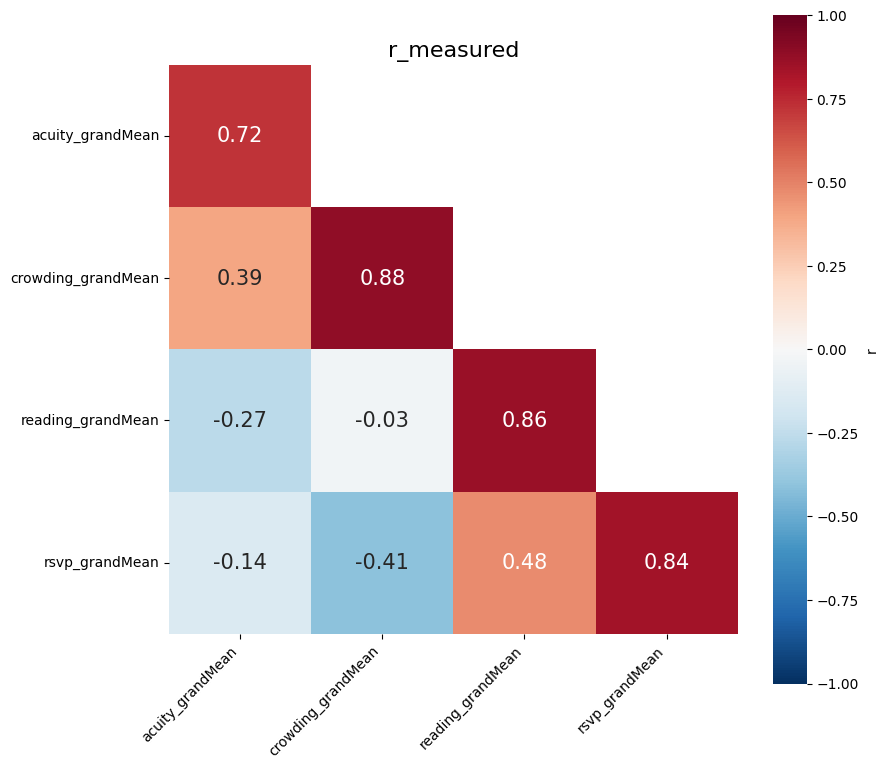

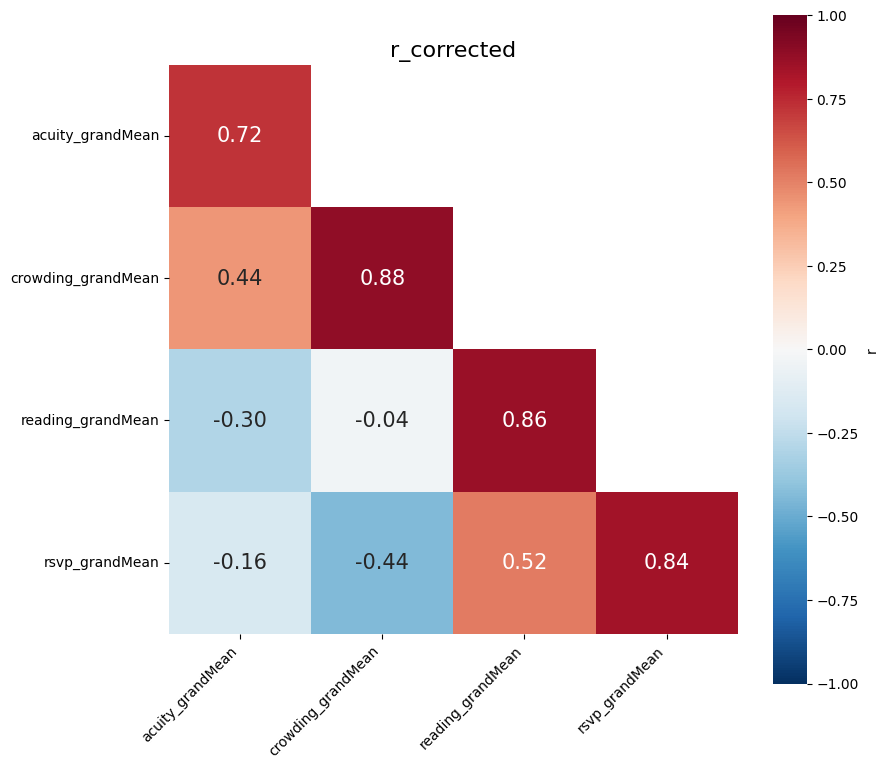

In [44]:
corr_mtx_r_measured = create_corr_mtx(corr_df, all_tasks_summary, var_ceiling_pairs_task, value_col="r_measured")
plot_mtx_heatmap(corr_mtx_r_measured, title='r_measured', fontSize=15)
corr_mtx_r_corrected = create_corr_mtx(corr_df, all_tasks_summary, var_ceiling_pairs_task, value_col="r_corrected")
plot_mtx_heatmap(corr_mtx_r_corrected, title='r_corrected', fontSize=15)

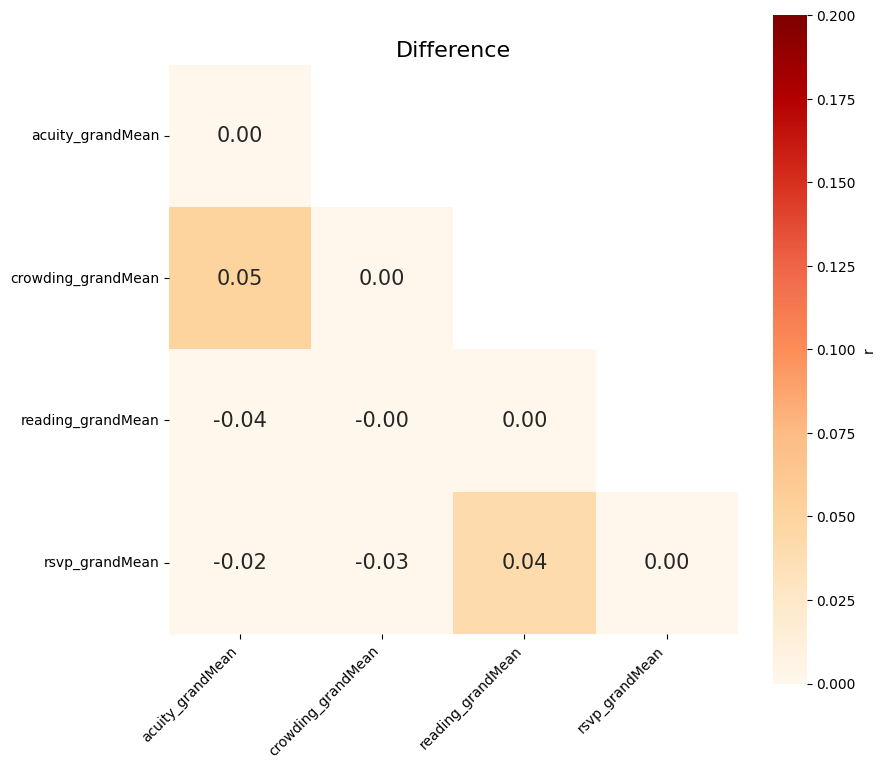

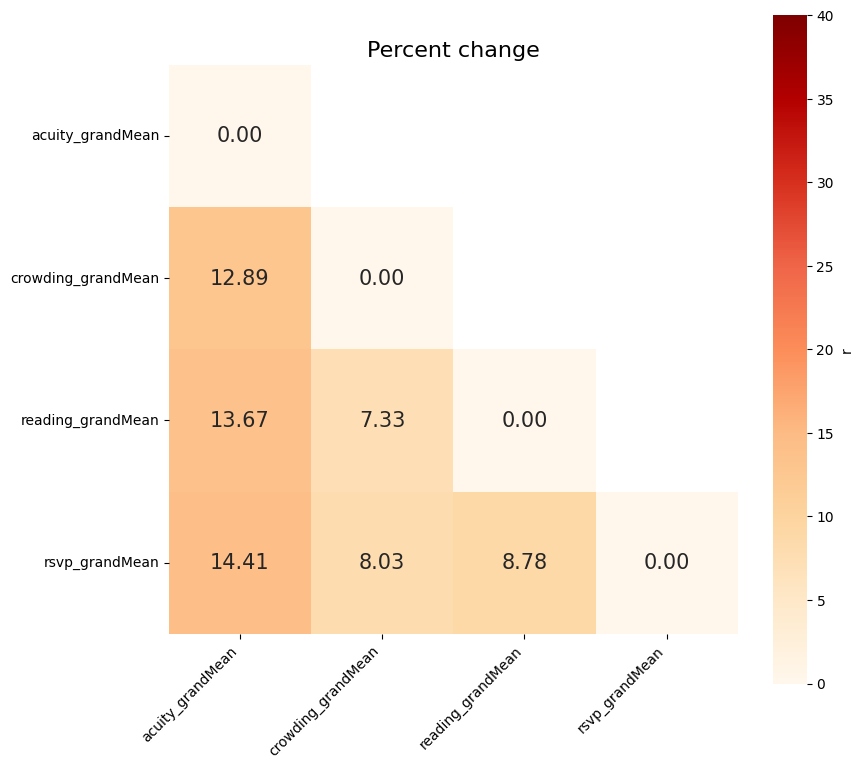

In [45]:
difference_mtx = corr_mtx_r_corrected - corr_mtx_r_measured 
plot_mtx_heatmap(difference_mtx, title='Difference', fontSize=15, valmin=0, valmax=0.2, colormap='OrRd')
percentchange_mtx = (corr_mtx_r_corrected - corr_mtx_r_measured) / corr_mtx_r_measured * 100
plot_mtx_heatmap(percentchange_mtx, title='Percent change', fontSize=15, valmin=0, valmax=40, colormap='OrRd')
